In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# NOTEBOOK DESCRIPTION
We use the dataset published by Commission for Energy
Regulation (CER) in Ireland for the experiments. The
dataset contains load profiles of over 6000 residential consumers
and small & medium enterprises for approximately one
and a half years (from July 1, 2009 to December 31, 2010)
with a half-hourly resolution. As we are also interested in the
forecasting performance on consumer aggregates at the higher
network levels, e.g., transformer stations or feeder loads, three
additional aggregates, representing small, medium and large
transformer stations are created. To generate realistic load
aggregates from the initial pool of individual load time series, a
total of 1000 time series are created.
<br>

The goal of this notebook is to show the intuition behind sampling aggregates of data from CER dataset. We did not use regular sampling. We have first clustered the original consumers from CER dataset and than created aggregates (representing transformer stations) with different daily profiles using clustering information while sampling. The idea is to create transfomer stations with different behaviors. <br>

To generate realistic load aggregates from the initial pool of individual load time series, a total of 1000 time series corresponding to the following groups were created for the experiments, i.e.:
- Individual consumers (single): 250 time series of individual consumers;
- Small transformer stations (sTS): 250 time series each having 50 consumers in an aggregate;
- Medium transformer stations (mTS): 250 time series each having 100 consumers in an aggregate;
- Large transformer stations (lTS) 250 time series each having 200 consumers in an aggregate.


Why we do not use regular sampling (where probability of chosing each consumer in a set is the same)? <br>
If you would use regular sampling (without replacement), all the resulting aggregated time series would be very similar, thus all the time series in a particular aggregate would represent "average" behaviour. E.g. for creating 250 large transformer stations (larger transformer stations have 200 consumers) time series, we have to first randomly sample 200 consumers, aggregate the load and repeat 250x. In the end, this would result in having 250 time series, which are quite similar. It would not make sense to train a model on a 1000 time series, where time series in a set are so similar to each other. <br>

In this notebook, we only load the final created dataset that was used for experiments, whereas we do not share a code for creating aggregates. Nevertheless, the sampling procedure is as follows:<br>
1. We leverage Monte Carlo sampling to produce realistic load aggregates representing transformer stations with different daily profile behaviours (various residential and commercial areas and a mix of them). Different daily profile behaviours are first determined by clustering.<br>
2. Cluster input set of individual time series (residential & commercial) in 10 groups using KMeans, where each customer is represented with mean daily profiles of week day, Saturday and Sunday. Final results provide cluster label for each customer.<br>
3. Let $n_{samples}$ and $n_{samples\,in\,agg}$ denote number of consumers and number of samples in aggregate respectively.
For every aggregate type in our case $n_{samples} = 250$, whereas for small transformer station  $n_{samples\,in\,agg} = 50$.<br>
4. Next, let $clust_{share}$ denote share of consumers in a particular cluster group (sampled in range between 5 % and 95 %). According to $clust_{share}$, we calculate number of customers in aggregate that corresponds to particular cluster centroid. E.g. if $clust_{share}$ = 0.8 and $n_{samples\,in\,agg} = 50$, there will be 40 consumers (80 %) selected that correspond to particular cluster (every time creating one series out of 50 total series). Other 20 % of customers, will be selected randomly without replacement. In this case, that transformer station will be dominated by consumers in that particular cluster group.<br>
5. Apart from load aggregates representing transformer stations, there are also 250 individual consumers, which are sampled randomly without replacement.

# LIBS

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import os

%matplotlib inline
mpl.rcParams['figure.facecolor'] = "w"

Matplotlib is building the font cache; this may take a moment.


# FUNCTIONS

In [3]:
def reshape2threedays(df_in):
    """
    DESCRIPTION: Reshapes input dataframe with hourly resolution to a dataframe, 
                 where every consumer has a weekly mean profile in each row. 
    
    Input:
    df_in (pd.DataFrame): Dataframe holding time series data with hourly resolution in every column. Indices are timestamps.
    
    Output:
    df (pd.DataFrame): Dataframe holding time series data with daily resolution and hours in every columns.
    
    """
    df = df_in.copy()
    df.columns.name = "ts_id"
    df.index.name = "timestamp"
    df = df.unstack().reset_index()
    
    days = df.timestamp.rename("dayofweek").dt.dayofweek
    days[days < 5] = 0
    
    df = (pd.pivot_table(df, 
                         values=0, 
                         index=df.ts_id,
                         columns=[days, 
                                  df.timestamp.rename("hour").dt.hour]
                         )
            .round(3)
         )
    return df


def normalize_df(df):
    """
    DESCRIPTION: Normalizes input dataframe according to daily maximum.
    """
    # fillna is for profiles with only zeros per day
    return df.apply(lambda s: s / df.max(axis=1)).fillna(0)

    
    
def plot_clustered_profiles(df, clust, n_cols=3, alpha=0.2):
    """
    DESCRIPTION: Plots one subplot per cluster, where each subplot contains
                    all profiles in a particular cluster together with a cluster centroid.
    """

    clust_perc = 100 * clust.value_counts(normalize=True)

    n_rows = np.ceil(clust.nunique() / n_cols)
    fontsize = 15
    x_axis = ["Week day", "Saturdays", "Sundays"]

    fig = plt.figure(figsize=[15, n_rows*4])

    for i, clust_n in enumerate(clust_perc.index):

        ax = fig.add_subplot(n_rows, n_cols, i+1)
        df_plot = df[clust == clust_n]
        
        step = 10 if df_plot.shape[0] > 500 else 1  # plot less profiles

        plt.plot(df_plot.iloc[::step].T.values, alpha=alpha, color="dodgerblue")
        df_plot.mean().plot(ax=plt.gca(), alpha=1, color="k", legend=False);

        plt.title("clust: {}, perc: {:.1f}%".format(clust_n, 
                                                    clust_perc.loc[clust_n]), 
                                                    fontsize=fontsize+5);
        plt.xticks(np.arange(0, 72, 24), x_axis, fontsize=12);
        plt.yticks(np.arange(0, 1.1, 0.1), fontsize=fontsize);

        plt.xlabel("Hours", fontsize=fontsize)
        plt.ylabel("$P/P_{max}$", fontsize=fontsize)
        plt.grid()
        plt.ylim(0, 1)

    plt.tight_layout()

# 0. INPUT DATA

In [4]:
# FOLDERS PATHS
cwd = os.path.dirname(os.getcwd())
folder_in = cwd + "/input_data/"

# DATA
data = pd.read_csv(folder_in + "data.csv", index_col="timestamp").astype(np.float32)
data.index = pd.to_datetime(data.index)

Our dataset is stored in DataFrame data, where timestamps are indices and ts_id's are columns. E.g. first column has $ts_{id} = 0$ etc. First 250 series correspond to individual consumers, next 250 series to small transformer stations etc.

In [5]:
data.shape

(25728, 1000)

In [6]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
timestamp,,,,,,,,,,,,,,,,,,,,,
2009-07-14 00:00:00,0.760,0.592,1.614,0.358,0.286,0.140,0.460,0.410,1.384,1.958,...,101.822006,168.178009,262.874023,151.407990,279.238007,125.795998,331.898010,109.206001,114.315994,278.312012
2009-07-14 00:30:00,0.808,0.588,0.566,0.206,0.288,0.252,0.498,0.368,1.372,3.260,...,94.399994,142.209991,214.033997,130.778000,225.395996,102.136002,314.873962,90.020004,91.412003,216.598007
2009-07-14 01:00:00,0.646,0.470,0.294,0.292,0.288,0.138,0.380,0.260,1.298,1.252,...,75.587997,128.830002,176.235992,111.841995,190.748001,84.360001,299.174011,78.278000,76.369995,189.097992
2009-07-14 01:30:00,0.288,0.592,0.344,0.332,0.288,0.208,0.548,0.208,1.380,1.322,...,69.875999,111.858002,161.548004,100.436005,170.343994,79.839996,271.511993,76.524002,72.003998,170.701996
2009-07-14 02:00:00,0.224,0.566,0.242,0.254,0.290,0.176,0.386,0.218,1.298,1.046,...,67.206001,105.178001,144.040009,89.346001,154.808014,75.636002,274.394012,65.656006,69.680000,149.277985


# 1. CLUSTERING CREATED TIME SERIES
In order to show the importance of creating aggregate types with different behaviours (instead of using simple random sampling), we cluster the resulting time series.

In [7]:
X_weekly_mean = reshape2threedays(data.resample("1h").mean())

X_weekly_mean_norm = normalize_df(X_weekly_mean)
print("X_weekly_mean_norm shape:", X_weekly_mean.shape)

n_clusters = 10
model = KMeans(n_clusters).fit(X_weekly_mean_norm.values)
clust = pd.Series(model.labels_, index=X_weekly_mean_norm.index)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/pandas/core/series.py:1021: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  self._where(~key, value, inplace=True)


X_weekly_mean_norm shape: (1000, 72)


As you can see below, time series in a dataset have different daily behaviours.

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:57: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:57: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:57: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:57: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 an

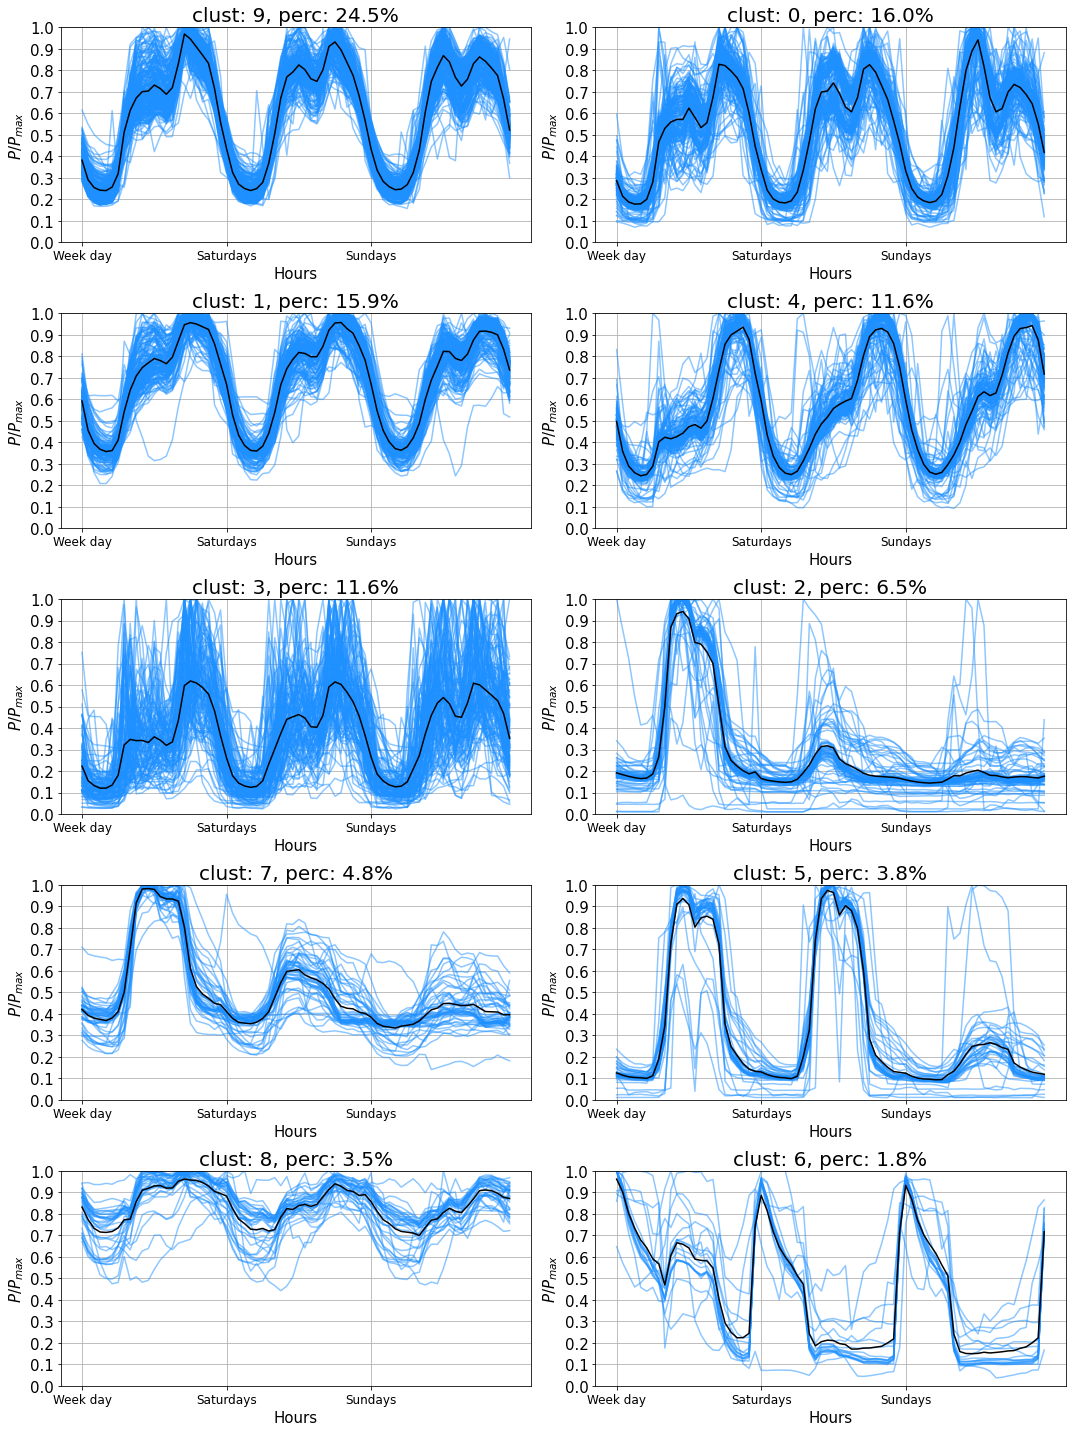

In [8]:
plot_clustered_profiles(X_weekly_mean_norm, clust, n_cols=2, alpha=0.5);